In [1]:
import tensorflow
import tensorflow as tf
from tensorflow.keras import models
tf.compat.v1.disable_eager_execution()
import matplotlib.image as mpimg
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
import numpy as np

#-------------------------------------------------
#Utility function for displaying filters as images
#-------------------------------------------------

def deprocess_image(x):
    
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
    

#---------------------------------------------------------------------------------------------------
#Utility function for generating patterns for given layer starting from empty input image and then 
#applying Stochastic Gradient Ascent for maximizing the response of particular filter in given layer
#---------------------------------------------------------------------------------------------------

def generate_pattern(model, layer_name, filter_index, size=150):
    
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(80):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)


def hand_scan(img_path):
        
    model = tf.keras.models.load_model('/Users/rvupp/opt/anaconda3/denenet121_forearm_fracture_detection_model.h5', compile=True)
#     print(model.summary())
    model.load_weights('/Users/rvupp/opt/anaconda3/denenet121_forearm_fracture_detection_weights.h5')
    
    img=mpimg.imread(img_path)
    plt.imshow(img)
    
    from keras.preprocessing import image
    import numpy as np
    
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    print(x.shape)
    x = np.expand_dims(x, axis=0)
    print(x.shape)
    from keras.applications.vgg16 import preprocess_input
    import pandas as pd
    x = preprocess_input(x, data_format='channels_last')
    
    
    
    
    preds = model.predict(x)
    print("..................")
    print("..................")
    print("..................")
    type(preds)
    
    decode_predictions = tf.keras.applications.imagenet_utils.decode_predictions(preds, top=3)
    
    print(decode_predictions)
    
    predictions = pd.DataFrame(decode_predictions[0],columns=['col1','category','probability']).iloc[:,1:]
    print(predictions)

    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]


    layer_outputs = [layer.output for layer in model.layers[50:]]
    # load a new image
#     img=mpimg.imread(img_path)
#     plt.imshow(img)
    
    from keras.preprocessing import image
    import numpy as np
    
    img2 = image.load_img(img_path, target_size=(224, 224))
    x2 = image.img_to_array(img2)
    print(x2.shape)
    x2 = np.expand_dims(x2, axis=0)
    print(x2.shape)
    from keras.applications.vgg16 import preprocess_input
    import pandas as pd
    x2 = preprocess_input(x2, data_format='channels_last')
    
#     print(layer_outputs)
    
    activation_model = models.Model(inputs=model.inputs, outputs=layer_outputs)
    
    activations = activation_model.predict(x2, steps = 1)
    
    layer_names = ['conv2_block1_1_conv', 'conv2_block1_1_relu', 'conv3_block12_2_conv', 'pool3_relu', 'conv5_block16_2_conv', 'relu']
    activ_list = [activations[0], activations[1]]

    images_per_row = 12

    for layer_name, layer_activation in zip(layer_names, activ_list):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
    
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(2*scale * display_grid.shape[1], 2*scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='plasma')
        plt.savefig(layer_name+"_grid.jpg", bbox_inches='tight')
        
        #------------------------------------------------------------------------------------------
#Generating convolution layer filters for intermediate layers using above utility functions
#------------------------------------------------------------------------------------------

    layer_name = 'conv5_block16_2_conv'
    size = 224
    margin = 5
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):
        for j in range(8):
            filter_img = generate_pattern(activation_model, layer_name, i + (j * 8), size=size)
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
        
    plt.figure(figsize=(10, 10))
    plt.savefig('/results')
    
    
    
#-----------------------------------------------------------------------------------
#Here, I am initializing an InceptionV3 model and making prediction on a test image.
#Following which, I am creating a activaton heatmap of the last layer of this model,
#which is a mixed layer. This heatmap is then superimposed on the original image.
#-----------------------------------------------------------------------------------

    model = InceptionV3(weights='imagenet')
    img_path = img_path

    img = image.load_img(img_path, target_size=(IMG_SIZE[0], IMG_SIZE[1]))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    print ("Predicted: ", decode_predictions(preds, top=3)[0])

#985 is the class index for class 'Daisy' in Imagenet dataset on which my model is pre-trained
    flower_output = model.output[:, 1]
    last_conv_layer = model.get_layer('mixed10')

    grads = K.gradients(flower_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])

#2048 is the number of filters/channels in 'mixed10' layer
    for i in range(2048):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.savefig(heatmap)

#Using cv2 to superimpose the heatmap on original image to clearly illustrate activated portion of image
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite('image_name.jpg', superimposed_img)

    
    return None
    

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


(224, 224, 3)
(1, 224, 224, 3)
..................
..................
..................
[[('n01440764', 'tench', 0.999884), ('n01443537', 'goldfish', 0.00011596091)]]
   category  probability
0     tench     0.999884
1  goldfish     0.000116
(224, 224, 3)
(1, 224, 224, 3)


/Users/rvupp/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
/Users/rvupp/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: divide by zero encountered in true_divide


ValueError: slice index 32 of dimension 3 out of bounds. for 'strided_slice_5' (op: 'StridedSlice') with input shapes: [?,7,7,32], [4], [4], [4] and with computed input tensors: input[1] = <0 0 0 32>, input[2] = <0 0 0 33>, input[3] = <1 1 1 1>.

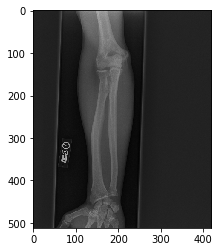

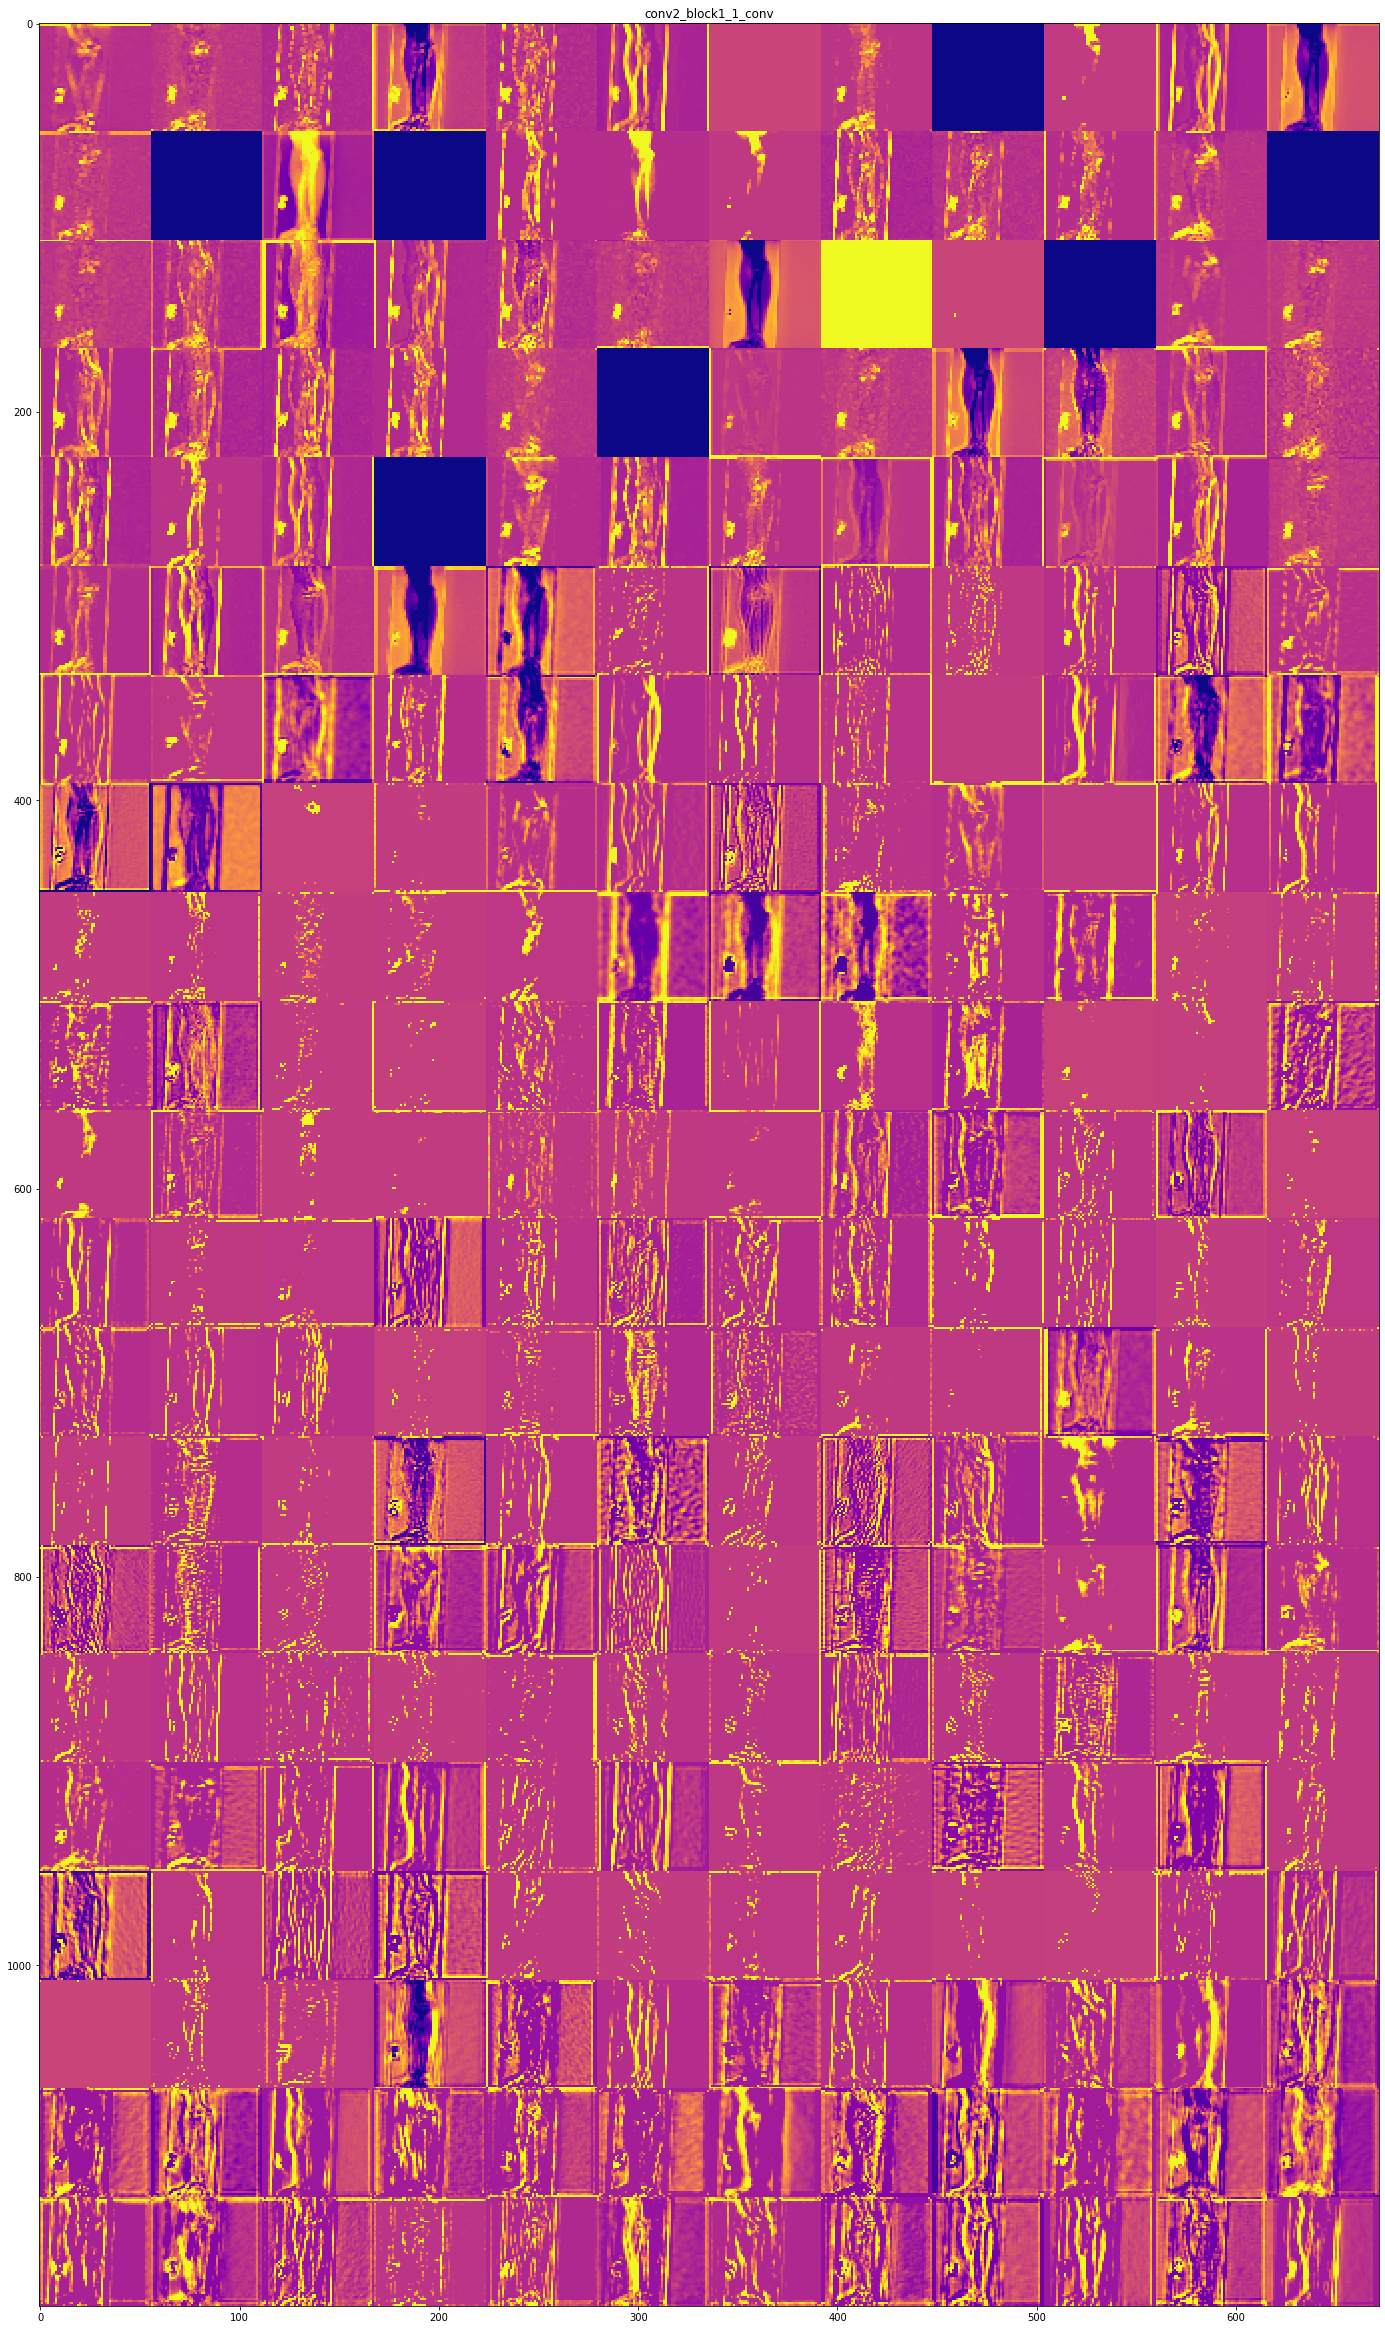

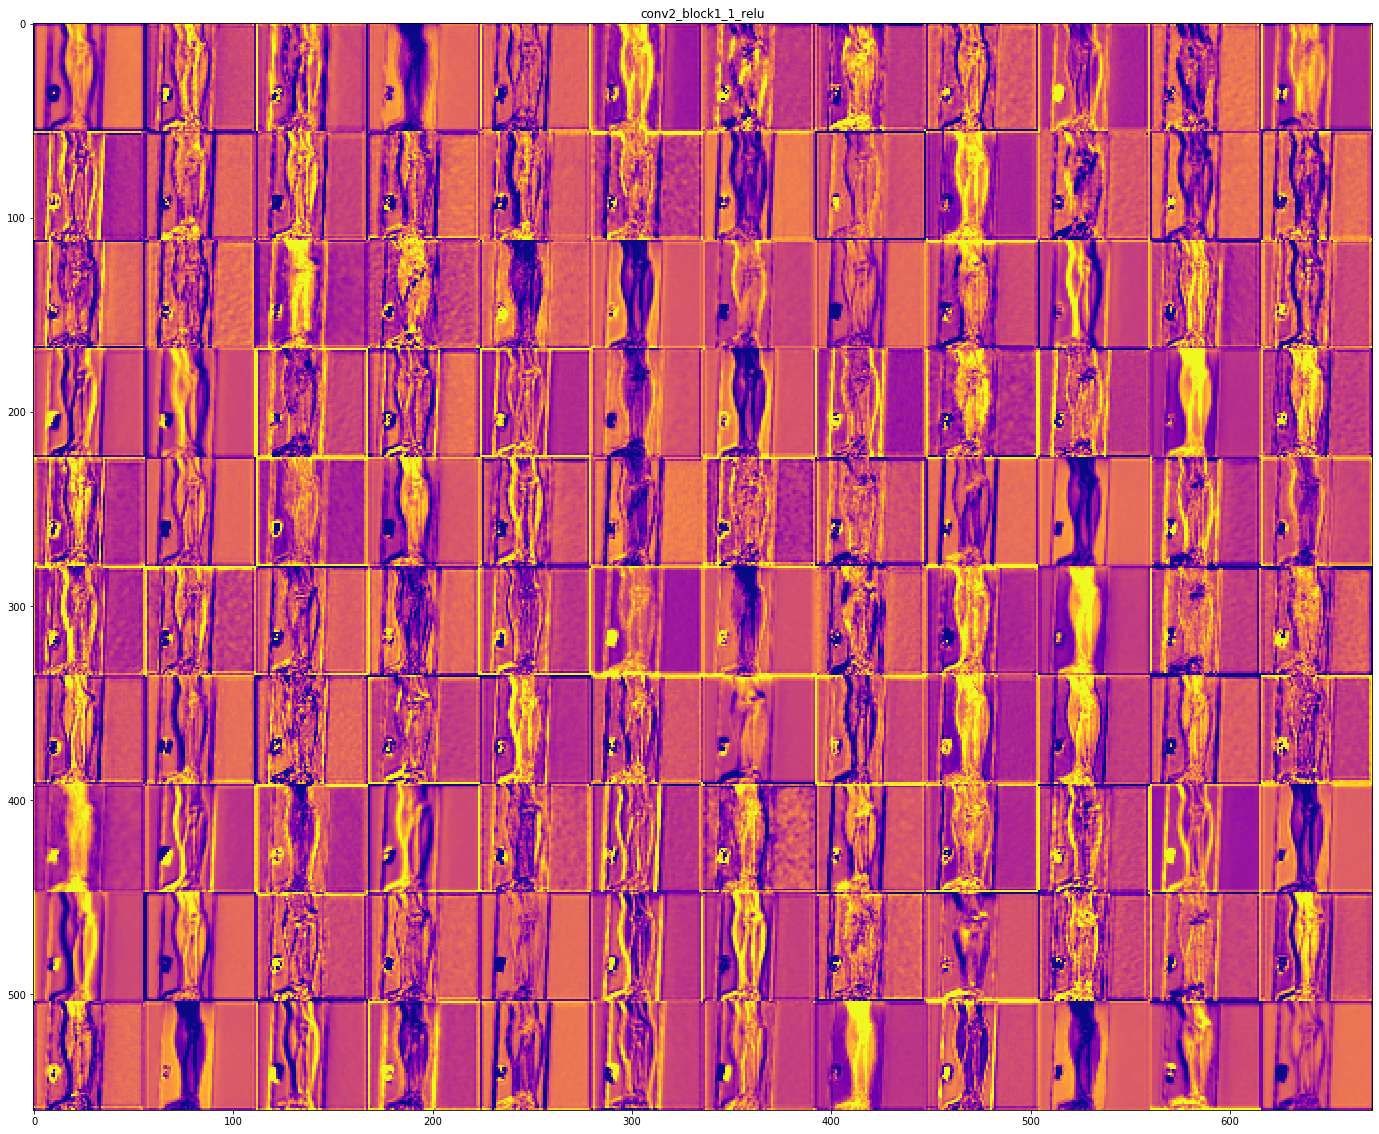

In [2]:
image_path = '/Users/rvupp/opt/anaconda3/BoneFractureDetectionMURA/MURA-v1.1/valid/XR_FOREARM/patient11450/study1_negative/image2.png'
hand_scan(image_path)

In [ ]:
# import cv2
# # def get_class_activation_map(img_path):
# img_path = '/Users/rvupp/opt/anaconda3/BoneFractureDetectionMURA/MURA-v1.1/valid/XR_HAND/patient11267/study1_negative/image3.png'
# #load the image
# img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (299, 299))
# img = np.expand_dims(img, axis = 0)
    
    
# #load the saved model from disk
    
# model = tf.keras.models.load_model('/Users/rvupp/opt/anaconda3/inceptionv3_fracture_detection_hand_model_keras_2_33layers_trained.h5')
# print(model.summary())
# model.load_weights('/Users/rvupp/opt/anaconda3/inceptionv3_fracture_detection_hand_model_weights_2_33layers_trained.h5')
    

    
# #     return None
    

In [ ]:
# predict = model.predict(img)

In [ ]:
# img_path = '/Users/rvupp/opt/anaconda3/BoneFractureDetectionMURA/MURA-v1.1/valid/XR_HAND/patient11267/study1_negative/image3.png'
# get_class_activation_map(img_path)

In [ ]:
# target_class = np.argmax(predict[0])
# target_class

In [ ]:
# !pip install git+git://github.com/keras-team/keras.git --upgrade --no-deps

In [ ]:
# abc_output = model.output[:, 0]
# last_conv = model.get_layer(index=0).get_layer('conv2d_93')
# (abc_output)

In [ ]:
# # model.output[:, target_class]
# def replace_none_with_zero(l):
#     return [0 if i==None else i for i in l]
# grads = K.gradients(model.output[:, 0], last_conv.output)[0]
# type(grads)

In [ ]:
# pooled_grads = K.mean(grads, axis=(0,1,2))

In [ ]:
# iterate = K.function*([model.input], [pooled_grads, last_conv.output[0]])